# LQR for Double Inverted Pendulum

Compute a linear optimal control law to stabilize the double inverted pendulum system when subjected to small deviations from the rest position.

In [9]:
# a few packages we need to import
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 
import pickle

# Simulation of the double inverted pendulum model and dispaly functions

In [10]:
def simulate_double_inverted_pendulum(x0, K, uff, horizon_length, M=1., m1=0.5, m2=0.2, L1=0.8, L2=0.6, g=9.81):
    """
    
    D(q)*q"+C(q,q') = F(q)
    q=[x, v, theta_1, omega_1, theta_2, omega_2]'
    
    """
    delta_t = 0.01
    
    x=np.empty([6,horizon_length+1])
    x[:,0] = x0
    
    u=np.empty([horizon_length])
    
    # distance between pivot point and center of the mass of pendulums
    l1 = L1/2
    l2 = L2/2
    # Compute the Moment of Inertia
    I1 = (m1*l1**2)/3
    I2 = (m2*l2**2)/3
    
    for i in range(horizon_length):
        u[i] = K[i].dot(x[:,i]) + uff[i]
        # D(q)
        D11 = M+m1+m2
        D12 = (m1*l1+m2*L1)*np.cos(x[2,i])
        D13 = m2*l2*np.cos(x[4,i])
        D21 = D12
        D22 = I1+m1*l1**2+m2*L1**2
        D23 = m2*l2*L1*np.cos(x[2,i]-x[4,i])
        D31 = D13
        D32 = D23
        D33 = I2+m2*l2**2
        # C(q,q')
        C12 = -(m1*l1+m2*L1)*np.sin(x[2,i])*x[3,i]
        C13 = -m2*l2*np.sin(x[4,i])*x[5,i]
        C23 = m2*l2*L1*np.sin(x[2,i]-x[4,i])*x[5,i]
        C32 = -m2*l2*L1*np.sin(x[2,i]-x[4,i])*x[3,i]
        # F(q)
        F1 = u[i]
        F2 = (m1*l1+m2*L1)*g*np.sin(x[2,i])
        F3 = m2*g*l2*np.sin(x[4,i])
        
        # compute derivative of omega_2 (angular acceleration)
        w1_coef = -((D31*D22-D21*D32)*(D31*C12-D11*C32)+(-D11*D32+D31*D12)*D21*C32)
        w2_coef = -((D31*D22-D21*D32)*D31*C13-(-D11*D32+D31*D12)*D31*C23)
        const = -(-D11*D32+D31*D12)*(D31*F2-D21*F3)+(D31*F1-D11*F3)*(D31*D22-D21*D32)
        dw2_denominator = (-D11*D32+D31*D12)*(D33*D21-D31*D23)+(D31*D22-D21*D32)*(D31*D13-D11*D33)
        dw2 = ( w1_coef*x[3,i] + w2_coef*x[5,i] + const ) / dw2_denominator
        
        # then compute derivative of omega_1 (angular acceleration)
        dw1 = ( (D31*F2-D21*F3)+(D33*D21-D31*D23)*dw2+D21*C32*x[3,i]-D31*C23*x[5,i] )/(D31*D22-D21*D32)
        
        # then compute acceleration a
        a = (F3-D32*dw1-D33*dw2-C32*x[3,i])/D31
        
        dx = np.array([ x[1,i], a, x[3,i], dw1, x[5,i], dw2 ])
        x[:,i+1] = x[:,i] + delta_t*dx
    return x,u

In [11]:
def animate_double_inverted_pendulum(x):
    """
    This function makes an animation showing the behavior of the double inverted pendulum
    takes as input the result of a simulation
    """
    #subsample
    plotx = x[:,0::5] # Take one for every five
    
    fig = matplotlib.figure.Figure(figsize=[6,3.5])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-3,3], ylim=[-1.6,1.9])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend1 = plotx[0,i] + np.sin(plotx[2,i])*0.8
        y_pend1 = cart_height + np.cos(plotx[2,i])*0.8
        x_pend2 = x_pend1 + np.sin(plotx[4,i])*0.6
        y_pend2 = y_pend1 + np.cos(plotx[4,i])*0.6
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend1], [cart_height, y_pend1])
        list_of_lines[5].set_data([x_pend1, x_pend2], [y_pend1, y_pend2])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=50, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

# Solve ricatti equations

In [12]:
def solve_ricatti_equations(A,B,Q,R,horizon_length):
    """
    This function solves the backward Riccatti equations for regulator problems of the form
    min xQx + sum(xQx + uRu) subject to xn+1 = Axn + Bun
    
    Arguments:
    A, B, Q, R: numpy arrays defining the problem
    horizon_length: length of the horizon
    
    Returns:
    P: list of numpy arrays containing Pn from N to 0
    K: list of numpy arrays containing Kn from N-1 to 0
    """
    P = [1]*horizon_length #will contain the list of Ps from N to 0
    K = [1]*(horizon_length-1) #will contain the list of Ks from N-1 to 0

    N = horizon_length-1
    P[N] = Q
    for n in range(N-1,-1,-1):
        K[n] = -np.linalg.pinv( R+B.T.dot(P[n+1]).dot(B) ).dot(B.T.dot(P[n+1]).dot(A))
        P[n] = Q + A.T.dot(P[n+1]).dot(A) + A.T.dot(P[n+1]).dot(B).dot(K[n])
    
    return P,K

# Check controllability of the system

In [13]:
def check_controllability(A,B):
    """
    This function check  the controllabilitystate for system
    c=[B AB A^2B A^3B]
    """
    c=np.concatenate([B, np.dot(A, B), np.dot(A, A).dot(B),np.dot(A, A.dot(A)).dot(B),np.dot(A, A.dot(A.dot(A))).dot(B),np.dot(A, A.dot(A.dot(A.dot(A)))).dot(B)], axis=1)
    R=np.linalg.matrix_rank(c)
    print('rank is',R)
    if R< np.linalg.matrix_rank(A):
        print('is not controllable')
    else:print('is controllable')

In [14]:
length = 1001;
Q = np.mat([ [10,0,0,0,0,0],[0,1,0,0,0,0],[0,0,100,0,0,0],[0,0,0,50,0,0],[0,0,0,0,1000,0],[0,0,0,0,0,1000] ])
R = 0.01

# initial conditions
x0 = np.array([0.2, 0.1, 0.2, 0., -0.2, 0.])

# simulate the system
M=1.
m1=0.5
m2=0.2
L1=0.8
L2=0.6
g=9.81

# distance between pivot point and center of the mass of pendulums
l1 = L1/2
l2 = L2/2
# Compute the Moment of Inertia
I1 = (m1*l1**2)/3
I2 = (m2*l2**2)/3

W = M+m1+m2
d=I1*I2*W+I2*L1**2*M*m2+I2*L1**2*m1*m2+I2*l1**2*M*m1+I1*l2**2*M*m2+I1*l2**2*m1*m2+I2*l1**2*m1*m2-2*I2*L1*l1*m1*m2+l1**2*l2**2*M*m1*m2
A1=np.mat([ [0,d,0,0,0,0],
            [0,0,-g*(L1*m2+l1*m1)*(l1*m1*m2*l2**2+I2*L1*m2+I2*l1*m1),0,-g*l2**2*m2**2*(m1*l1**2-L1*m1*l1+I1),0],
            [0,0,0,d,0,0],
            [0,0,g*(L1*m2+l1*m1)*(I2*W+l2**2*M*m2+l2**2*m1*m2),0,-g*l2**2*m2**2*(L1*M+L1*m1-l1*m1),0],
            [0,0,0,0,0,d],
            [0,0,-g*l2*m2*(L1*m2+l1*m1)*(L1*M+L1*m1-l1*m1),0,g*l2*m2*(I1*W+l1**2*M*m1+l1**2*m1*m2+L1**2*M*m2+L1**2*m1*m2-2*L1*l1*m1*m2),0]
          ])/d
B1=np.mat([[0],
           [I2*m2*L1**2+m1*m2*l1**2*l2**2+I2*m1*l1**2+I1*m2*l2**2+I1*I2],
           [0],
           [-(l1*m1*m2*l2**2+I2*L1*m2+I2*l1*m1)],
           [0],
           [-l2*m2*(m1*l1**2-L1*m1*l1+I1)]
          ])/d

A1=np.identity(6)+0.01*A1
B1=0.01*B1

[ P,K ] = solve_ricatti_equations(A1,B1,Q,R,length)

horizon_length = 1000 #this will simulate 10 seconds (since deltat = 0.01)
uff = [0.]
uff = uff*horizon_length
x,u = simulate_double_inverted_pendulum(x0, K, uff, horizon_length, M=1., m1=0.5, m2=0.2, L1=0.8, L2=0.6, g=9.81)

In [15]:
check_controllability(A1,B1)

('rank is', 6)
is controllable


<IPython.core.display.Javascript object>


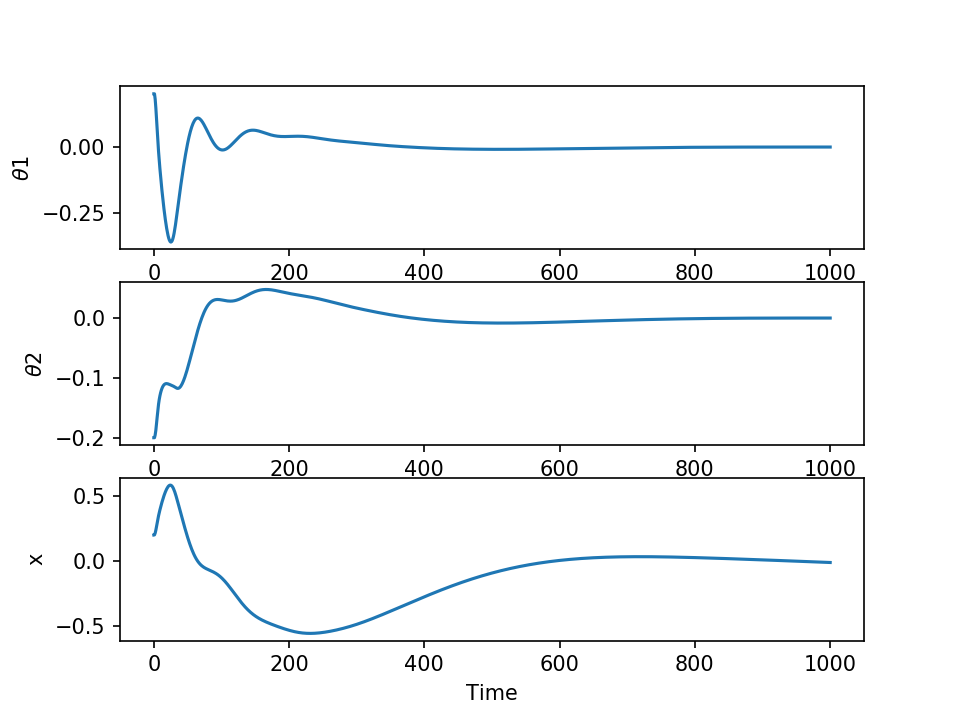

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABelG1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU3IHIyOTY5IGQ0MDk5ZGQgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE5IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA9PZYiE
ADf//vbw/gU2O5jQlxHN6J0zH78VuLo0N73OAAADAAADAAAI0IvBbWOwLYz4AAAFvtB4MZv8wEPF
ttSaBc7vHNeHxD06O543V4TzzNnjaIbsxkDqh3EP14qXpvKrCvQ++U1ZHKdz4HIvSdcjAF2i3Q1V
/zXvM0PmoWrTrjbEVrvcCF1YZlmd1iCamjMtqTEF6x50RwlInjyse9Wgw7hKyTfouB2X5phBtqFH
2brGzM8q4Uy5zFUBBR5FzCPyndqibkiD4Ls4PNpRgJ2EO4X5QlAH29pgfDlCARaO6Lypi4BMlNCv
UNeBYhmeAgmndLb1yuVwLQCrhah/8KhLDnN1BQnl2F5P0EKc6S3lS3OwAQMTlMN6zle1a7368OUE
5HhGKO7ltibBzWHVl/Ne2b4B3obHVxvfjqMFXrGSPuXQ/wa2Tn5u9JU0P0NN5RTF+X9yXvju0bmI
9cCBkctSgXekyIJSg7fVDCE84H3p0B0Siq60FGEu3E7EbsD9yTgwI5P9+AcIg86E/pf3q+v3zEgB
ObkDzFvZUDdLFNcj1ZY8IT0y2Lllh+pXFPwlsG4PdE9tnp4FYnfiX/ucyCjrf0SXStEepfHdjrdm
MSD9SVlpNd8KCM9EYT02sEMGJ0OTwT1duXkEteiPxrlI6LPRGANQlXuO1Bh+jc6l1oJz4LrN5Ua5
mtBFi/+KGk3OWef6vo/0HK6xNZ3M3mEu8Wp5fGH3/M2ZpxhsUrfbxF/nwPpwbiH4QlWeG+KKUR80
Aamgxke8SloMlLPn5YBHvdFguXxsu29nDQpFG8TWsdevOll+quPkuphPt/nk/s6nA2DYxDf4NA1u
vPFdvrjj6/reXoqHJf7Yt/MKwEABZg9mNPpxqQc8vm6D250FQT5+gG0eBkkXpqZpor94QwrgUd5l
1670/lZDXrkHIcxKO128QTX2WZbBm7H2WDsFOaombowOCSMn24n+HC9rFHF/c08C5XUTVnQU8qJU
vs7umMLHT3hsT9TV46CdJ4XCBWxWBRYcbtjQ5orfD1lW70I8BJ/OZkBHyD7CkeWtSspPk88zAH23
Pp5cfa+XCispS+nga27FJZ/sFiB1klihXH3ITstiMxFsghlHVLMnnY/JeWgYYzrHjivk6B0Q9F/f
YFwRa61oKrviH9kO3swArjHi/o8ndJVLQaq1TajXv3JhGJFSK66j1ejjOWE0KcJqfdYh8CaGTgAH
t7shjrYKGoA8aTUlsn7+z+6H7ODiEv0MWws8dLK2yeBS0wVQA80RrOEWE9if4suGwD5goRcI+ckH
WBCJ+wEDJamkgacxdO85UdCgBKj5zdoNgUg9r+Uv73pPgqmIHKOnb+aavZKAClPtQ1OsAAfffhzB
krP3+2Z0R+L7TY1g9uGMSyhcNdi/dlLh+VZyQ7udd2nL54mmEDvmtWXf7hII2YRwvricip7jquR/
eZCfwN2evyCjyClSHLoRLINDK7iKe+7hQ2gSoUKQ43lFpdDysJIMDkKeR7KT5MgL4NgGZqkY8D7o
AIj9SbZMJiFP7o8AwtNhNy1d7/Ipnml3vgcrcs392JMrq8PHJqbe+KXAdeGAedv7++jCJsovLGBt
gDHikrE2h7curO3v7ZxEbIxjjaz3yAQPzLaBWWZ2XgM2rlToqEM3MNHcd+fsThUpPQ7titGpWA8j
qodr1CrF18Wi+0w/TfnYBe7oRoHTDn5Ii2z8GcdA8WfuadyP95X2sBQSz2+s4N3zbrF1ESG3upkx
M3shXuJeo/U0S5g92skRECryFTm6dnmdhfe/4WNmdn10OBJKzHvk8MoqfBbD2k7j9zt/WJ+60t5b
iBaf/T5loVlMXKaTboIKAZd39Rjvn1jEeRQFWDjlvx3glyEukXGqbN0ILFdS1kwKQh9TFXNNS28M
Bo8zDypgWQCHVcAzA9qOcv6j1h1kAZLDQJ/iL6/aFCFZdXpqeN8Cd28oiI1OzouMPXBZu2wsb4Iq
wgqSXd3Kc6WLL+pkzS96ORc9KHxKU5c4HeN7wmEDRpIZBXCSJ3XHtvUZVUoZmeIg2d5i/+qnRFqm
vxHPE9pr39oY0UIKAAcziETSeMSED2ILkP0h8YcVbNsMcIspdRI37Z7T8wJQXleSWzBFRc3z63/e
MMi12qaWqkEemJAaTAqs1llcMUetgSz7y/J6GFc/wz/uaM3UN5EN0j714Oj3Uo+pdxkk/f7Uv70b
im7Ga0i3BMALiy6qGGmjn4tAAYK9kx9k7uABdANp1N4Yps+cVGEaWCGCsOnsaFwsKkF3iQFnooFX
JjMb+1v6KtA9bOPhlNqBRla6XSG0d4qnHrSJGR3UStE18AI4G+hZxNvWT8VYr3HJ0mGEupxtgS4q
M+GDJs9/mYqwJWUCrTNK6shH2p6AxZF/Se38fwP/WIsZNZO3mU9r42YDnXDf6qUr4eBCg9ru2nAv
+DhQa26DFwVRevg+DdLjmWor48IOaDSno7WifZQCzYm2FQ9RtFcaHwPkOf+9J168fVNXWdShbDGi
+8I27e4Llm4f4tg4D0m/IxnHiw2N0/SZsB/GwCNyW46aJ84zVcxsBgoptOaWU1lvesABjR5aT9Cv
LPkdRZt9iOlaXjZk+IW7a9SfDScjaOm6P7wgWtunabeJ9T8dDi8wfH3l8F2C5VjyEIOjBSX/FStr
tc5sW9wMrC3yDmgbGJz+qhHiWSxYZt8NJWenSG8Cea7nqbctCpnYFFrAqATSly5x78detYxR6LBn
h/WRULXkH0+G4spK5AYP7VQq6+SO3trpS/ocpkDZ7roy7vLg5TSNsb/LX388xzS2sKW9gJkNyWiv
5MsMx9lqG/Si5fHtnQQ6x2sHpL9WytK0GhhorM2y/A73Pa5/D1O0bs7TsljTQ6OlAed6zQZWdyYo
273WK6TQ2XvEI9K9Afb6r

In [16]:
# plot x and theta as a function of time
plt.figure()
plt.subplot(3,1,1)
plt.plot(x[2,:])
plt.ylabel(r'$\theta1$')
plt.subplot(3,1,2)
plt.plot(x[4,:])
plt.ylabel(r'$\theta2$')
plt.subplot(3,1,3)
plt.plot(x[0,:])
plt.ylabel('x')
plt.xlabel('Time')
# make an animation of the double inverted pendulum
animate_double_inverted_pendulum(x)